In [1]:
#  UX-Section Summary Initialization
EXPLAIN = True  

def banner(title, body=None):
    line = "=" * len(title)
    print(f"\n{line}\n{title}\n{line}")
    if body and EXPLAIN:
        print(body)

In [2]:
# Boostrap
from pathlib import Path
import shutil, os, re, json, subprocess, datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

banner(
    "1) Bootstrap: folders & one-time migration",
    "Creates the project folders, pulls source CSV/XLSX from Desktop into the project, "
    "and migrates any legacy ./outputs into the new outputs folder."
)

PROJECT_DIR = Path("Dock Optimization Project")
DATADIR     = PROJECT_DIR / "data"
OUTDIR      = PROJECT_DIR / "outputs"
for p in (PROJECT_DIR, DATADIR, OUTDIR):
    p.mkdir(parents=True, exist_ok=True)

# One-time migration of legacy outputs
LEGACY = Path("outputs")
if LEGACY.exists():
    for p in LEGACY.glob("*"):
        if p.is_file():
            shutil.copy2(p, OUTDIR / p.name)
    print("✓ Migrated prior files from ./outputs →", OUTDIR)
else:
    print("No legacy ./outputs to migrate (ok).")

# Source locations 
DESKTOP_PATH = r"C:\Users\13346\OneDrive\Desktop"
INBOUND_NAME  = "Inbound.csv"
OUTBOUND_NAME = "outbound.csv"

# Copy project/data 
src_inb = Path(DESKTOP_PATH) / INBOUND_NAME
src_out = Path(DESKTOP_PATH) / OUTBOUND_NAME
dst_inb = DATADIR / INBOUND_NAME
dst_out = DATADIR / OUTBOUND_NAME
for s,d in [(src_inb,dst_inb),(src_out,dst_out)]:
    try:
        if s.exists() and not d.exists():
            shutil.copy2(s, d)
    except Exception as e:
        print("Skip copy:", s, "->", d, "| Reason:", e)

INBOUND_PATH  = str(dst_inb if dst_inb.exists() else src_inb)
OUTBOUND_PATH = str(dst_out if dst_out.exists() else src_out)

print("Project:", PROJECT_DIR.resolve())
print("Data   :", DATADIR.resolve())
print("Outputs:", OUTDIR.resolve())



1) Bootstrap: folders & one-time migration
Creates the project folders, pulls source CSV/XLSX from Desktop into the project, and migrates any legacy ./outputs into the new outputs folder.
✓ Migrated prior files from ./outputs → Dock Optimization Project\outputs
Project: C:\Users\13346\Dock Optimization Project\outputs\Dock Optimization Project\Dock Optimization Project
Data   : C:\Users\13346\Dock Optimization Project\outputs\Dock Optimization Project\Dock Optimization Project\data
Outputs: C:\Users\13346\Dock Optimization Project\outputs\Dock Optimization Project\Dock Optimization Project\outputs


In [3]:
# Parameters
banner(
    "2) Model configuration",
    "Geometry converts door separation to feet; time model uses speed and fixed per-move handling. "
    "CUBE is the primary flow metric with automatic fallback to SHIPMENTS if CUBE is all-zero on either side."
)
# Metric priority
METRIC_PRIORITY = ["cube", "shipments", "weight_lb"]

# Dock: 38×38 for MCI
N_INBOUND_DOORS  = 38
N_OUTBOUND_DOORS = 38

# Reserve last K outbound doors for city P&D
NUM_PD_OUTBOUND_DOORS = 0

# Geometry (feet)
BAY_SPACING_FT    = 12.0
AISLE_CROSSING_FT = 60.0
TURN_PENALTY_FT   = 10.0

# Time / handling model
FORKLIFT_SPEED_FT_S  = 6.0      # ~4.1 mph
SECONDS_PER_MOVE_FIX = 10.0     # pick/drop overhead per move (sec)

# Trailer sanity checks
LINEHAUL_CAP_LB = 22000  # 48ft pups
PD_CAP_LB       = 48000  # 53ft P&D

MCI_CODE = "MCI"



2) Model configuration
Geometry converts door separation to feet; time model uses speed and fixed per-move handling. CUBE is the primary flow metric with automatic fallback to SHIPMENTS if CUBE is all-zero on either side.


In [4]:
# Load and Normalize
banner(
    "3) Load & normalize",
    "Reads your Inbound/Outbound files; detects lane/date/cube/shipments/weight columns; "
    "converts dates; filters to MCI: FROM MCI for outbound (types O/B), TO MCI for inbound (types D/B)."
)

def read_any(path: str) -> pd.DataFrame:
    p = Path(path)
    if p.suffix.lower() in (".xlsx",".xls"):
        try:
            return pd.read_excel(path)
        except Exception:
            return pd.read_excel(path, engine="openpyxl")
    # CSV read
    for enc in ("utf-8-sig","utf-8","latin-1"):
        for args in (dict(sep=None, engine="python"), dict()):
            try:
                return pd.read_csv(path, encoding=enc, **args)
            except Exception:
                pass
    return pd.read_csv(path)

inb_raw = read_any(INBOUND_PATH)
out_raw = read_any(OUTBOUND_PATH)

def parse_date_series(s: pd.Series) -> pd.Series:
    parsed = pd.to_datetime(s, errors="coerce")
    if parsed.isna().mean() > 0.5:
        s2 = s.astype(str).str.replace(r"[^0-9]","", regex=True)
        parsed2 = pd.to_datetime(s2, format="%Y%m%d", errors="coerce")
        return parsed2
    return parsed

def detect_lane_column(df: pd.DataFrame, is_outbound: bool):
    pats = [r"lane", r"\bdst\b|dest|destination|terminal|\bsc\b|hub"] if is_outbound \
           else [r"lane", r"\bori\b|origin|load.?ori|terminal|\bsc\b|hub"]
    for ptn in pats:
        for c in df.columns:
            if re.search(ptn, str(c).lower()): return c
    return None

def detect_date_column(df: pd.DataFrame, prefer_regexes):
    cands=[]
    for c in df.columns:
        lc = str(c).lower()
        if any(re.search(rgx, lc) for rgx in prefer_regexes) or ("date" in lc or lc.endswith("dt")):
            parsed = parse_date_series(df[c])
            if (1.0 - float(parsed.isna().mean())) >= 0.2:
                cands.append((float(parsed.isna().mean()), c))
    if not cands: return None
    cands.sort(key=lambda x: x[0])
    return cands[0][1]

def pick_cube(df):      # Map CUBE columns
    for c in df.columns:
        if re.search(r"\bcube\b", str(c), flags=re.I): return c
def pick_ship(df):      # Map SHIPMENTS
    for c in df.columns:
        if re.search(r"shipments?|pro.*count|sfx_pro_count|cb_pro_count", str(c), flags=re.I): return c
def pick_weight(df):    # Map WEIGHT
    for c in df.columns:
        if re.search(r"weight|wt|lbs?", str(c), flags=re.I): return c
    return None

def normalize_frames(inb_raw: pd.DataFrame, out_raw: pd.DataFrame):
    inb_lane = detect_lane_column(inb_raw, is_outbound=False)
    out_lane = detect_lane_column(out_raw, is_outbound=True)
    inb_date = detect_date_column(inb_raw, [r"pu.*date|pickup", r"arriv", r"inb.*date"])
    out_date = detect_date_column(out_raw, [r"dispatch.*date|dispatch.*dt", r"load.*date|load.*dt",
                                            r"out.*date|out.*dt", r"dep.*date|dep.*dt"])

    inb_cube, out_cube = pick_cube(inb_raw), pick_cube(out_raw)
    inb_ship, out_ship = pick_ship(inb_raw), pick_ship(out_raw)
    inb_w, out_w       = pick_weight(inb_raw), pick_weight(out_raw)

    rn = lambda df, m: df.rename(columns={k:v for k,v in m.items() if k})

    inb = rn(inb_raw, {inb_lane:"INB_LANE", inb_date:"INB_DATE",
                       inb_cube:"INB_CUBE", inb_ship:"INB_SHIPMENTS", inb_w:"INB_WEIGHT_LB"})
    out = rn(out_raw, {out_lane:"OUT_LANE", out_date:"OUT_DATE",
                       out_cube:"OUT_CUBE", out_ship:"OUT_SHIPMENTS", out_w:"OUT_WEIGHT_LB"})

    if "INB_DATE" in inb.columns: inb["INB_DATE"] = parse_date_series(inb["INB_DATE"])
    if "OUT_DATE" in out.columns: out["OUT_DATE"] = parse_date_series(out["OUT_DATE"])

    # Ensure numeric
    for c in ("INB_CUBE","INB_SHIPMENTS","INB_WEIGHT_LB"):
        if c not in inb.columns: inb[c] = 0.0
        inb[c] = pd.to_numeric(inb[c], errors="coerce").fillna(0.0)
    for c in ("OUT_CUBE","OUT_SHIPMENTS","OUT_WEIGHT_LB"):
        if c not in out.columns: out[c] = 0.0
        out[c] = pd.to_numeric(out[c], errors="coerce").fillna(0.0)

    # Filter to MCI logic
    def _find(df, patterns):
        for c in df.columns:
            if any(re.search(p, str(c).lower()) for p in patterns):
                return c
        return None
    out_ori_sc   = _find(out, [r"\borigin\b", r"\bori(_sc)?\b", r"from[_\s-]*sc", r"from[_\s-]*term"])
    out_ori_type = _find(out, [r"ori.*type"])
    inb_dst_sc   = _find(inb, [r"\bdest(ination)?\b", r"\bdst(_sc)?\b", r"to[_\s-]*sc", r"to[_\s-]*term"])
    inb_dst_type = _find(inb, [r"dst.*type"])

    # Outbound legs that DEPART from MCI (Type O/B)
    if out_ori_sc is not None:
        mask_out = out[out_ori_sc].astype(str).str.upper().eq(MCI_CODE)
        if out_ori_type is not None:
            mask_out &= out[out_ori_type].astype(str).str.upper().isin(["O","B"])
        out = out.loc[mask_out].copy()

    # Inbound legs that ARRIVE to MCI (Type D/B)
    if inb_dst_sc is not None:
        mask_in = inb[inb_dst_sc].astype(str).str.upper().eq(MCI_CODE)
        if inb_dst_type is not None:
            mask_in &= inb[inb_dst_type].astype(str).str.upper().isin(["B","D"])
        inb = inb.loc[mask_in].copy()

    print("Detected:", {
        "INB_LANE": inb_lane, "INB_DATE": inb_date, "INB_CUBE": inb_cube, "INB_SHIPMENTS": inb_ship, "INB_WEIGHT_LB": inb_w,
        "OUT_LANE": out_lane, "OUT_DATE": out_date, "OUT_CUBE": out_cube, "OUT_SHIPMENTS": out_ship, "OUT_WEIGHT_LB": out_w
    })
    print(f"Rows after MCI filter → inbound: {len(inb):,} | outbound: {len(out):,}")
    return inb, out

inb_df, out_df = normalize_frames(inb_raw, out_raw)


3) Load & normalize
Reads your Inbound/Outbound files; detects lane/date/cube/shipments/weight columns; converts dates; filters to MCI: FROM MCI for outbound (types O/B), TO MCI for inbound (types D/B).
Detected: {'INB_LANE': 'LANE_ID', 'INB_DATE': 'PU DATE', 'INB_CUBE': 'CUBE', 'INB_SHIPMENTS': 'SHIPMENTS', 'INB_WEIGHT_LB': None, 'OUT_LANE': 'LANE_ID', 'OUT_DATE': 'PU_DATE', 'OUT_CUBE': 'CUBE', 'OUT_SHIPMENTS': 'SHIPMENTS', 'OUT_WEIGHT_LB': None}
Rows after MCI filter → inbound: 9,157 | outbound: 8,077


In [5]:
# Flow Matrix
banner(
    "4) Build flow matrix (CUBE preferred) with robust date matching",
    "Within each day I allocated inbound volume to outbound lanes proportionally by the outbound totals. "
    "If same-day matches are sparse we allow ±1 day, then weekly buckets, else a whole-window proportional fallback."
)

def choose_metric(inb: pd.DataFrame, out: pd.DataFrame, priority):
    totals = {
        "cube":      (inb.get("INB_CUBE", pd.Series([0])).sum(),      out.get("OUT_CUBE", pd.Series([0])).sum()),
        "shipments": (inb.get("INB_SHIPMENTS", pd.Series([0])).sum(), out.get("OUT_SHIPMENTS", pd.Series([0])).sum()),
        "weight_lb": (inb.get("INB_WEIGHT_LB", pd.Series([0])).sum(), out.get("OUT_WEIGHT_LB", pd.Series([0])).sum()),
    }
    for m in priority:
        a,b = totals[m]
        if a>0 and b>0:
            print(f"Selected metric: {m} (INB={a:,.0f}, OUT={b:,.0f})")
            return m
    return priority[-1]

metric_choice = choose_metric(inb_df, out_df, METRIC_PRIORITY)

def build_flow_matrix(inb: pd.DataFrame, out: pd.DataFrame, metric="cube"):
    im, om = {"cube":("INB_CUBE","OUT_CUBE"),
              "shipments":("INB_SHIPMENTS","OUT_SHIPMENTS"),
              "weight_lb":("INB_WEIGHT_LB","OUT_WEIGHT_LB")}[metric]
    inb2 = inb.dropna(subset=["INB_LANE","INB_DATE"]).copy()
    out2 = out.dropna(subset=["OUT_LANE","OUT_DATE"]).copy()

    def same_day():
        a = inb2.groupby([pd.Grouper(key="INB_DATE", freq="D"), "INB_LANE"])[im].sum().reset_index()
        b = out2.groupby([pd.Grouper(key="OUT_DATE", freq="D"), "OUT_LANE"])[om].sum().reset_index()
        return a.merge(b, left_on="INB_DATE", right_on="OUT_DATE", how="inner")

    def pm_one():
        a = inb2.copy(); b = out2.copy()
        a["INB_D"] = a["INB_DATE"].dt.floor("D"); b["OUT_D"] = b["OUT_DATE"].dt.floor("D")
        a = a.groupby(["INB_D","INB_LANE"])[im].sum().reset_index()
        b = b.groupby(["OUT_D","OUT_LANE"])[om].sum().reset_index()
        a["key"]=1; b["key"]=1
        cart = a.merge(b,on="key").drop(columns="key")
        cart = cart[(cart["OUT_D"]-cart["INB_D"]).abs()<=pd.Timedelta(days=1)]
        return cart.rename(columns={"INB_D":"INB_DATE","OUT_D":"OUT_DATE"})

    def weekly():
        a = inb2.copy(); b = out2.copy()
        a["W"] = a["INB_DATE"].dt.to_period("W").dt.start_time
        b["W"] = b["OUT_DATE"].dt.to_period("W").dt.start_time
        a = a.groupby(["W","INB_LANE"])[im].sum().reset_index().rename(columns={"W":"INB_DATE"})
        b = b.groupby(["W","OUT_LANE"])[om].sum().reset_index().rename(columns={"W":"OUT_DATE"})
        return a.merge(b, left_on="INB_DATE", right_on="OUT_DATE", how="inner")

    merged = same_day()
    if merged.empty: merged = pm_one()
    if merged.empty: merged = weekly()

    if merged.empty:
        it = inb2.groupby("INB_LANE")[im].sum().rename("INB_T").reset_index()
        ot = out2.groupby("OUT_LANE")[om].sum().rename("OUT_T").reset_index()
        ot["OUT_SHARE"] = ot["OUT_T"] / max(ot["OUT_T"].sum(),1e-9)
        it["key"]=1; ot["key"]=1
        x = it.merge(ot,on="key").drop(columns="key")
        x["FLOW"] = x["INB_T"] * x["OUT_SHARE"]
        return x.pivot_table(index="INB_LANE", columns="OUT_LANE", values="FLOW",
                             aggfunc="sum", fill_value=0.0)

    merged["OUT_TOTAL"] = merged.groupby("OUT_DATE")[om].transform("sum").replace(0, np.nan)
    merged["PROP"] = merged[om] / merged["OUT_TOTAL"]
    merged["FLOW"] = merged[im] * merged["PROP"]
    return merged.pivot_table(index="INB_LANE", columns="OUT_LANE", values="FLOW",
                              aggfunc="sum", fill_value=0.0)

F_df = build_flow_matrix(inb_df, out_df, metric_choice)
F_df.to_csv(OUTDIR / f"flow_matrix_{metric_choice}.csv", encoding="utf-8")
print("✓ Flow matrix:", F_df.shape, "→", OUTDIR / f"flow_matrix_{metric_choice}.csv")


4) Build flow matrix (CUBE preferred) with robust date matching
Within each day I allocated inbound volume to outbound lanes proportionally by the outbound totals. If same-day matches are sparse we allow ±1 day, then weekly buckets, else a whole-window proportional fallback.
Selected metric: cube (INB=1,032,450, OUT=907,701)
✓ Flow matrix: (2000, 1969) → Dock Optimization Project\outputs\flow_matrix_cube.csv



5) Select best 38×38 submatrix (max coverage)
Picks the 38 FROM and 38 TO lanes that capture the most flow mass overall. This is what I optimized on for door placement.
✓ Selected 38×38 | captured=229.06 (12.30% of total)
✓ Saved: Dock Optimization Project\outputs\heatmap_38x38_log.png


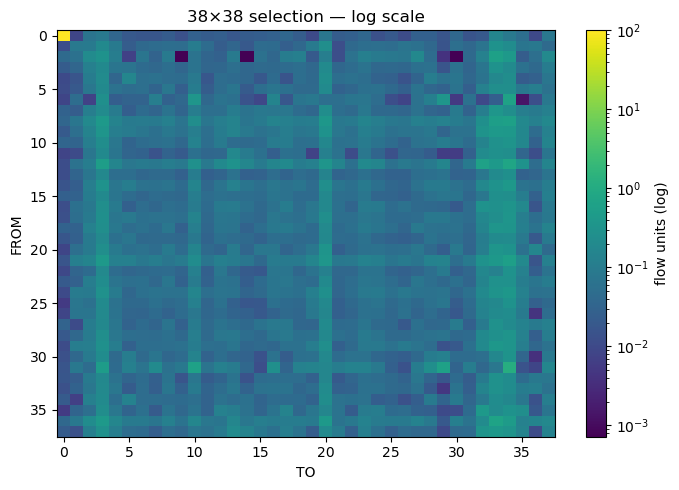

In [6]:
banner(
    "5) Select best 38×38 submatrix (max coverage)",
    "Picks the 38 FROM and 38 TO lanes that capture the most flow mass overall. "
    "This is what I optimized on for door placement."
)

def select_max_coverage(F: np.ndarray, rmax: int, cmax: int):
    m,n = F.shape
    cells = np.dstack(np.unravel_index(np.argsort(F.ravel())[::-1], (m,n)))[0]
    R,C=set(),set()
    for i,j in cells:
        if F[i,j]>0: R.add(i); C.add(j); break
    def gain_row(i): return float(F[i, list(C)].sum()) if C else float(F[i,:].max())
    def gain_col(j): return float(F[list(R), j].sum()) if R else float(F[:,j].max())
    while len(R)<rmax or len(C)<cmax:
        best_r=(-1,-1.0); best_c=(-1,-1.0)
        if len(R)<rmax:
            for i in range(m):
                if i in R: continue
                g=gain_row(i)
                if g>best_r[1]: best_r=(i,g)
        if len(C)<cmax:
            for j in range(n):
                if j in C: continue
                g=gain_col(j)
                if g>best_c[1]: best_c=(j,g)
        if best_r[1]<=0 and best_c[1]<=0:
            for i,j in cells:
                if ((i not in R and len(R)<rmax) or (j not in C and len(C)<cmax)):
                    if i not in R and len(R)<rmax: R.add(i)
                    if j not in C and len(C)<cmax: C.add(j)
                    break
            else: break
        else:
            if (best_r[1]>=best_c[1] and len(R)<rmax) or len(C)>=cmax:
                R.add(best_r[0])
            else:
                C.add(best_c[0])
    return sorted(R)[:rmax], sorted(C)[:cmax]

F_full = F_df.values.astype(float)
R_sel, C_sel = select_max_coverage(F_full, N_INBOUND_DOORS, N_OUTBOUND_DOORS)
F_use_df = F_df.iloc[R_sel, C_sel].copy()
F = F_use_df.values.astype(float)
INB_ORDER = list(F_use_df.index)   # FROM (to MCI)
OUT_ORDER = list(F_use_df.columns) # TO (from MCI)

captured = float(F.sum())
coverage_pct = 100*captured/max(F_full.sum(),1e-9)
print(f"✓ Selected 38×38 | captured={captured:,.2f} ({coverage_pct:.2f}% of total)")

# Heatmaps for review
arr = F.astype(float)
plt.figure(figsize=(7,5))
eps = max(arr[arr>0].min(), 1e-9) if (arr>0).any() else 1e-9
plt.imshow(arr+eps, aspect="auto", norm=LogNorm(vmin=eps, vmax=arr.max()+eps))
plt.colorbar(label="flow units (log)")
plt.title("38×38 selection — log scale")
plt.xlabel("TO"); plt.ylabel("FROM")
plt.tight_layout(); plt.savefig(OUTDIR/"heatmap_38x38_log.png", dpi=180, bbox_inches="tight")
print("✓ Saved:", OUTDIR/"heatmap_38x38_log.png")


In [7]:
# Distance Matrix
banner(
    "6) Distance matrix (feet)",
    "Manhattan-style distance model: crossing the main aisle + along-dock distance + turn penalty."
)

def build_distance_matrix(n_in:int, n_out:int, bay:float, cross:float, turn:float) -> np.ndarray:
    P = np.arange(n_in).reshape(-1,1)
    Q = np.arange(n_out).reshape(1,-1)
    along = np.abs(P - Q) * bay
    return cross + along + turn

D = build_distance_matrix(N_INBOUND_DOORS, N_OUTBOUND_DOORS, BAY_SPACING_FT, AISLE_CROSSING_FT, TURN_PENALTY_FT)
pd.DataFrame(D).to_csv(OUTDIR / "distance_matrix_ft.csv", index=False, encoding="utf-8")
print("✓ Distance matrix:", D.shape, "→", OUTDIR / "distance_matrix_ft.csv")


6) Distance matrix (feet)
Manhattan-style distance model: crossing the main aisle + along-dock distance + turn penalty.
✓ Distance matrix: (38, 38) → Dock Optimization Project\outputs\distance_matrix_ft.csv


In [8]:
# Optimizer
banner(
    "7) Optimize door assignments",
    "Objective: minimize J(π,σ)=Σ F_ij·d(π(i),σ(j)) with optional soft penalties: "
    "congestion smoothing and keep-similar-lanes-close. Hungarian + local swap polish."
)

# Secondary effects (set >0 to emphasize)
LAMBDA_CONG_IN  = 0.00
LAMBDA_CONG_OUT = 0.02
LAMBDA_IN_CLUSTER  = 0.00
LAMBDA_OUT_CLUSTER = 0.03
DENSITY_WINDOW  = 3

S_in  = F @ F.T
S_out = F.T @ F
_BAY  = BAY_SPACING_FT

def door_workloads(F, pin, pout):
    Win  = F.sum(axis=1)[pin]
    Wout = F.sum(axis=0)[pout]
    return Win, Wout

def density(vec, window=3):
    return np.convolve(vec, np.ones(window), mode="same")

def congestion_penalty(F, pin, pout):
    Win, Wout = door_workloads(F, pin, pout)
    din, dout = density(Win, DENSITY_WINDOW), density(Wout, DENSITY_WINDOW)
    return LAMBDA_CONG_IN*np.dot(din,din) + LAMBDA_CONG_OUT*np.dot(dout,dout)

def cluster_penalty(pin, pout):
    add=0.0
    if LAMBDA_IN_CLUSTER>0:
        for a in range(len(pin)):
            for b in range(a+1,len(pin)):
                add += S_in[a,b]*abs(pin[a]-pin[b])*_BAY
    if LAMBDA_OUT_CLUSTER>0:
        for a in range(len(pout)):
            for b in range(a+1,len(pout)):
                add += S_out[a,b]*abs(pout[a]-pout[b])*_BAY
    return add

def augmented_objective(F, D, pin, pout):
    return float((F * D[np.ix_(pin, pout)]).sum()) + congestion_penalty(F,pin,pout) + cluster_penalty(pin,pout)

try:
    from scipy.optimize import linear_sum_assignment
    SCIPY_OK = True
except Exception:
    SCIPY_OK = False

def hungarian_or_greedy(cost):
    if SCIPY_OK:
        r,c = linear_sum_assignment(cost)
        perm = np.zeros_like(r); perm[r]=c
        return perm
    # greedy fallback
    n_rows, n_cols = cost.shape
    perm = -np.ones(n_rows, dtype=int); used=set()
    order = np.argsort(cost.min(axis=1))
    for r in order:
        tmp = cost[r].copy()
        if used: tmp[list(used)] = np.inf
        j = int(np.argmin(tmp))
        perm[r]=j; used.add(j)
    return perm

def inbound_cost(F, D, pout): return F @ D[:, pout].T
def outbound_cost(F, D, pin): return F.T @ D[pin, :]

def polish_swaps(F, D, pin, pout, side="inbound", passes=2):
    cur = augmented_objective(F,D,pin,pout)
    for _ in range(passes):
        improved=False
        if side=="inbound":
            for a in range(len(pin)):
                for b in range(a+1,len(pin)):
                    p=pin.copy(); p[a],p[b]=p[b],p[a]
                    val=augmented_objective(F,D,p,pout)
                    if val+1e-9<cur: pin=p; cur=val; improved=True
        else:
            for a in range(len(pout)):
                for b in range(a+1,len(pout)):
                    q=pout.copy(); q[a],q[b]=q[b],q[a]
                    val=augmented_objective(F,D,pin,q)
                    if val+1e-9<cur: pout=q; cur=val; improved=True
        if not improved: break
    return pin, pout, cur

def optimize(F, D, iters=8, reserve_pd_out=NUM_PD_OUTBOUND_DOORS):
    pin  = np.arange(min(F.shape[0], D.shape[0]))
    pout = np.arange(min(F.shape[1], D.shape[1]))
    hist=[]
    for _ in range(iters):
        Ci = inbound_cost(F,D,pout); pin  = hungarian_or_greedy(Ci)
        Co = outbound_cost(F,D, pin)

        # Reserve last K outbound doors for “P&D-eligible” lanes (highest outbound totals)
        if reserve_pd_out>0:
            reserved = list(range(D.shape[1]-reserve_pd_out, D.shape[1]))
            out_tot = F.sum(axis=0)
            pd_eligible = set(np.argsort(out_tot)[-reserve_pd_out:])
            big = 1e9
            for j in range(Co.shape[0]):
                if j not in pd_eligible:
                    Co[j, reserved] += big

        pout = hungarian_or_greedy(Co)
        pin, pout, o = polish_swaps(F,D,pin,pout,"inbound",2)
        pin, pout, o = polish_swaps(F,D,pin,pout,"outbound",2)
        hist.append(o)
    return pin, pout, hist

perm_in_opt, perm_out_opt, history = optimize(F, D, iters=8)


7) Optimize door assignments
Objective: minimize J(π,σ)=Σ F_ij·d(π(i),σ(j)) with optional soft penalties: congestion smoothing and keep-similar-lanes-close. Hungarian + local swap polish.


In [9]:
# Metrics
banner(
    "8) Executive math proof",
    "We compare: (a) door index = row/col identity (baseline) vs (b) optimized permutations. "
    "We report feet and time equivalents. The math report is written to JSON + Markdown."
)

def compute_metrics(F, D, pin, pout):
    dist = float((F * D[np.ix_(pin, pout)]).sum())
    units = float(F.sum())
    seconds = (dist / max(FORKLIFT_SPEED_FT_S,1e-6)) + units*SECONDS_PER_MOVE_FIX
    return dict(total_distance_ft=dist, total_units=units, estimated_seconds=seconds)

base = compute_metrics(F, D, np.arange(F.shape[0]), np.arange(F.shape[1]))
opt  = compute_metrics(F, D, perm_in_opt, perm_out_opt)

savings_ft  = base["total_distance_ft"] - opt["total_distance_ft"]
savings_pct = 100.0 * savings_ft / max(base["total_distance_ft"], 1e-9)
savings_hrs = (savings_ft / max(FORKLIFT_SPEED_FT_S,1e-6)) / 3600.0

print(f"Baseline distance (ft):  {base['total_distance_ft']:.0f}")
print(f"Optimized distance (ft): {opt['total_distance_ft']:.0f}")
print(f"Savings: {savings_ft:,.0f} ft ({savings_pct:.2f}%)  ≈ {savings_hrs:.2f} travel hours")

# Persist math report
report = {
    "config": {
        "N_INBOUND_DOORS": N_INBOUND_DOORS,
        "N_OUTBOUND_DOORS": N_OUTBOUND_DOORS,
        "BAY_SPACING_FT": BAY_SPACING_FT,
        "AISLE_CROSSING_FT": AISLE_CROSSING_FT,
        "TURN_PENALTY_FT": TURN_PENALTY_FT,
        "FORKLIFT_SPEED_FT_S": FORKLIFT_SPEED_FT_S,
        "SECONDS_PER_MOVE_FIX": SECONDS_PER_MOVE_FIX
    },
    "metric_used": metric_choice,
    "baseline": base,
    "optimized": opt,
    "savings": {"distance_ft": float(savings_ft), "percent": float(savings_pct),
                "travel_hours_equiv": float(savings_hrs)},
    "history": [float(x) for x in history],
}
with open(OUTDIR/"math_report.json", "w", encoding="utf-8") as f:
    json.dump(report, f, indent=2, ensure_ascii=False)

with open(OUTDIR/"math_report.md", "w", encoding="utf-8") as f:
    f.write(
f"""# Dock Layout Optimization — Math Proof (MCI)

**Objective**  
J(π,σ) = Σᵢ Σⱼ Fᵢⱼ · d(π(i), σ(j))

**Distance model**  
d(p,q) = {AISLE_CROSSING_FT} + {BAY_SPACING_FT}·|p−q| + {TURN_PENALTY_FT} (ft)

**Time model**  
t(p,q) = d(p,q)/{FORKLIFT_SPEED_FT_S} + {SECONDS_PER_MOVE_FIX}  (seconds per move)

## Results
- Baseline total distance (ft): {base['total_distance_ft']:.0f}
- Optimized total distance (ft): {opt['total_distance_ft']:.0f}
- Distance saved (ft): {savings_ft:.0f}  ({savings_pct:.2f}%)
- Travel-time savings (hrs): {savings_hrs:.2f}

All artifacts are in: `{OUTDIR}`.
""")
print("✓ Math report →", OUTDIR/"math_report.{json,md}")

# Save optimized assignments
pd.DataFrame({"INB_LANE": INB_ORDER, "INB_DOOR": (perm_in_opt + 1)}).to_csv(OUTDIR/"optimized_inbound_assignments.csv", index=False, encoding="utf-8")
pd.DataFrame({"OUT_LANE": OUT_ORDER, "OUT_DOOR": (perm_out_opt + 1)}).to_csv(OUTDIR/"optimized_outbound_assignments.csv", index=False, encoding="utf-8")

# Pairwise contributions (for audit)
D_sub_base = D[np.ix_(np.arange(F.shape[0]), np.arange(F.shape[1]))]
D_sub_opt  = D[np.ix_(perm_in_opt, perm_out_opt)]
base_pairs = pd.DataFrame(F * D_sub_base, index=INB_ORDER, columns=OUT_ORDER).stack().rename("distance_ft_contrib").reset_index().rename(columns={"level_0":"INB_LANE","level_1":"OUT_LANE"})
opt_pairs  = pd.DataFrame(F * D_sub_opt,  index=INB_ORDER, columns=OUT_ORDER).stack().rename("distance_ft_contrib").reset_index().rename(columns={"level_0":"INB_LANE","level_1":"OUT_LANE"})
base_pairs["flow_units"] = pd.DataFrame(F, index=INB_ORDER, columns=OUT_ORDER).stack().values
opt_pairs["flow_units"]  = pd.DataFrame(F, index=INB_ORDER, columns=OUT_ORDER).stack().values
base_pairs.sort_values("distance_ft_contrib", ascending=False).to_csv(OUTDIR/"pairwise_contrib_baseline.csv", index=False, encoding="utf-8")
opt_pairs.sort_values("distance_ft_contrib",  ascending=False).to_csv(OUTDIR/"pairwise_contrib_optimized.csv", index=False, encoding="utf-8")


8) Executive math proof
We compare: (a) door index = row/col identity (baseline) vs (b) optimized permutations. We report feet and time equivalents. The math report is written to JSON + Markdown.
Baseline distance (ft):  36180
Optimized distance (ft): 31326
Savings: 4,854 ft (13.42%)  ≈ 0.22 travel hours
✓ Math report → Dock Optimization Project\outputs\math_report.{json,md}



9) Dock diagram, break doors & 'why is this door here?' report
Top row = TO (outbound from MCI). Bottom row = FROM (inbound to MCI). Break-door suggestions mark high-throughput seams. The 'why-here' report ties each door to its top counterparts.
✓ Diagram: C:\Users\13346\Dock Optimization Project\outputs\Dock Optimization Project\Dock Optimization Project\outputs\dock_layout_MCI_updated.png
✓ Door labels: C:\Users\13346\Dock Optimization Project\outputs\Dock Optimization Project\Dock Optimization Project\outputs\door_labels_MCI_clean.csv
Break-door suggestions: [13, 27, 31, 36]
✓ Why-here report → Dock Optimization Project\outputs\why_here_report.xlsx


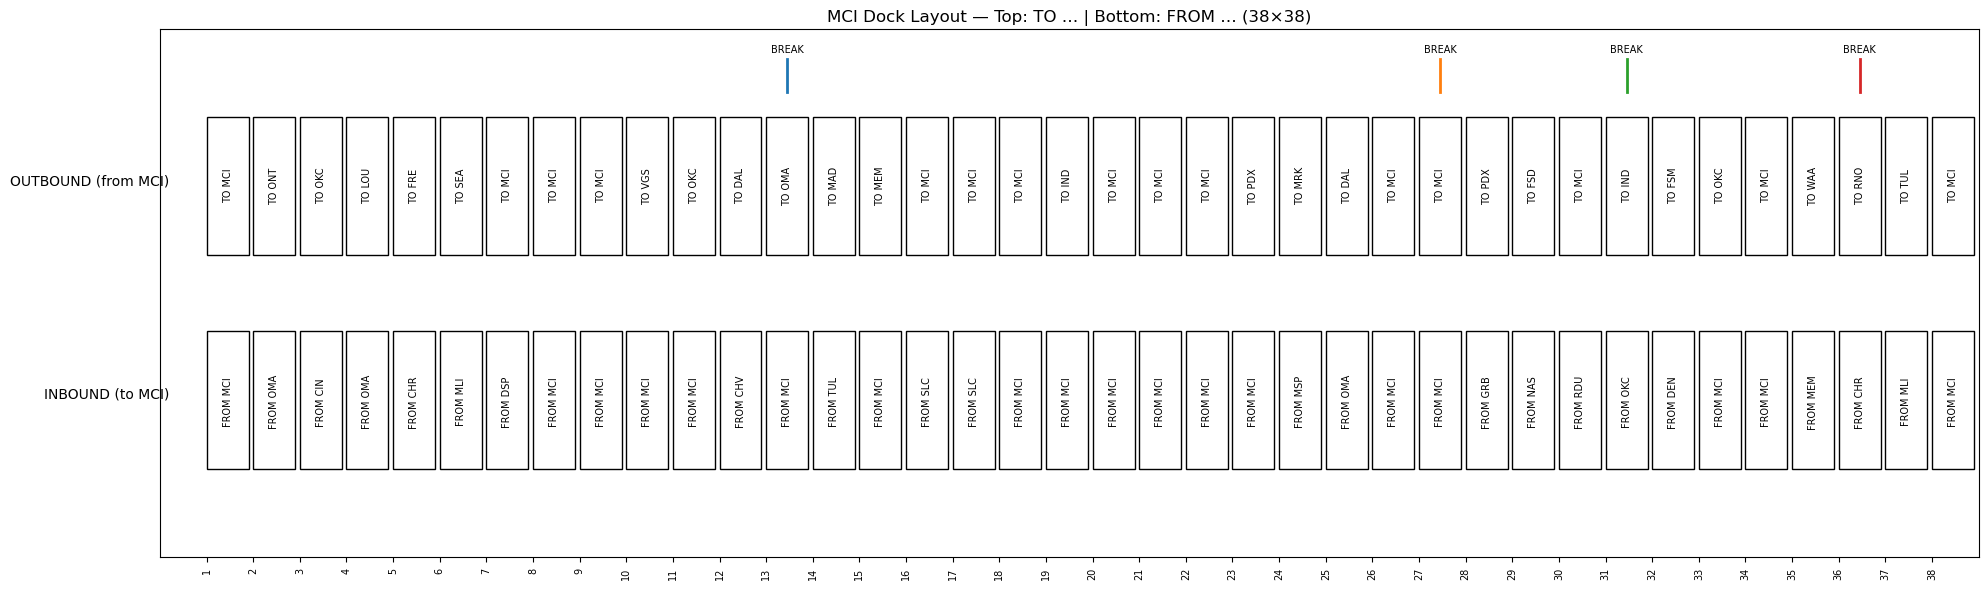

In [10]:
# Break Doors and Diagram
banner(
    "9) Dock diagram, break doors & 'why is this door here?' report",
    "Top row = TO (outbound from MCI). Bottom row = FROM (inbound to MCI). "
    "Break-door suggestions mark high-throughput seams. The 'why-here' report ties each door to its top counterparts."
)

def partner_label_from_lane(lane, side, mci=MCI_CODE):
    s = str(lane).upper()
    toks = [t for t in re.split(r"[^A-Z0-9]+", s) if t]
    if not toks:
        return f"{'TO' if side=='out' else 'FROM'} ?"
    if side == "out":
        if len(toks)>=2 and toks[0]==mci: partner = toks[1]
        elif mci in toks and toks.index(mci) < len(toks)-1: partner = toks[toks.index(mci)+1]
        else: partner = toks[-1]
        return f"TO {partner}"
    else:
        if len(toks)>=2 and toks[-1]==mci: partner = toks[-2]
        elif mci in toks and toks.index(mci) > 0: partner = toks[toks.index(mci)-1]
        else: partner = toks[0]
        return f"FROM {partner}"

def suggest_break_doors(F, pout, k=4, window=3):
    Wout = F.sum(axis=0)[pout]
    dens = np.convolve(Wout, np.ones(window), mode="same")
    picks=[]; cand=dens.copy()
    for _ in range(min(k, len(cand))):
        j = int(np.argmax(cand))
        picks.append(j+1)
        lo,hi=max(0,j-window), min(len(cand), j+window+1)
        cand[lo:hi] = -np.inf
    return sorted(picks)

# Compute default Break Doors
break_doors = suggest_break_doors(F, perm_out_opt, k=4, window=3)

# Door-ordered labels
in_door_to_lane_raw  = [INB_ORDER[i] for i in np.argsort(perm_in_opt)]   # bottom
out_door_to_lane_raw = [OUT_ORDER[j] for j in np.argsort(perm_out_opt)]  # top
in_labels  = [partner_label_from_lane(x, "in")  for x in in_door_to_lane_raw]
out_labels = [partner_label_from_lane(x, "out") for x in out_door_to_lane_raw]

# Save door map
door_map = pd.DataFrame({
    "OUT_DOOR": np.arange(1, len(out_labels)+1),
    "OUT_LANE_RAW": out_door_to_lane_raw,
    "OUT_LABEL": out_labels,
    "IN_DOOR": np.arange(1, len(in_labels)+1),
    "IN_LANE_RAW": in_door_to_lane_raw,
    "IN_LABEL": in_labels
})
door_map.to_csv(OUTDIR/"door_labels_MCI_clean.csv", index=False, encoding="utf-8")

# Draw diagram
IMG = OUTDIR / "dock_layout_MCI_updated.png"
fig, ax = plt.subplots(figsize=(20, 6))

# TOP (TO …)
y_out = 1.3
for i, label in enumerate(out_labels):
    ax.add_patch(plt.Rectangle((i, y_out-0.3), 0.9, 0.55, fill=False))
    ax.text(i+0.45, y_out-0.02, label, ha="center", va="center", rotation=90, fontsize=7)
ax.text(-0.8, y_out, "OUTBOUND (from MCI)", ha="right", va="center", fontsize=10)

# BOTTOM (FROM …)
y_in = 0.2
for i, label in enumerate(in_labels):
    ax.add_patch(plt.Rectangle((i, y_in-0.05), 0.9, 0.55, fill=False))
    ax.text(i+0.45, y_in+0.22, label, ha="center", va="center", rotation=90, fontsize=7)
ax.text(-0.8, y_in+0.25, "INBOUND (to MCI)", ha="right", va="center", fontsize=10)

# Break markers
for d in break_doors:
    x = d - 1 + 0.45
    ax.plot([x, x], [y_out+0.35, y_out+0.48], lw=2)
    ax.text(x, y_out+0.5, "BREAK", ha="center", va="bottom", fontsize=7)

N = max(len(in_labels), len(out_labels))
ax.set_xlim(-1, N); ax.set_ylim(-0.2, 1.9)
ax.set_xticks(range(N)); ax.set_xticklabels([str(i+1) for i in range(N)], rotation=90, fontsize=7)
ax.set_yticks([])
ax.set_title("MCI Dock Layout — Top: TO … | Bottom: FROM … (38×38)")
fig.tight_layout(); fig.savefig(IMG, dpi=220, bbox_inches="tight")

print("✓ Diagram:", IMG.resolve())
print("✓ Door labels:", (OUTDIR/"door_labels_MCI_clean.csv").resolve())
print("Break-door suggestions:", break_doors)

# Top counterparts + 80% flow radius
inv_in  = np.empty_like(perm_in_opt);  inv_in[perm_in_opt]   = np.arange(len(INB_ORDER))
inv_out = np.empty_like(perm_out_opt); inv_out[perm_out_opt] = np.arange(len(OUT_ORDER))
Dopt = D[np.ix_(perm_in_opt, perm_out_opt)]
F_arr = F.astype(float)
Cmat = F_arr * Dopt
row_flow = F_arr.sum(axis=1); col_flow = F_arr.sum(axis=0)
row_cost = Cmat.sum(axis=1);  col_cost = Cmat.sum(axis=0)

def flow_radius_row(i, target=0.80):
    w = F_arr[i,:]; tot = w.sum()
    if tot<=0: return 0,0.0
    pos = perm_out_opt
    order = np.argsort(pos); cum = np.cumsum(w[order])
    med_pos = pos[order[np.searchsorted(cum, tot/2.0)]]
    dist_doors = np.abs(pos - med_pos)
    order2 = np.argsort(dist_doors); cum2 = np.cumsum(w[order2]) / tot
    r = int(dist_doors[order2[np.searchsorted(cum2, target)]])
    return r, r*BAY_SPACING_FT

def flow_radius_col(j, target=0.80):
    w = F_arr[:,j]; tot = w.sum()
    if tot<=0: return 0,0.0
    pos = perm_in_opt
    order = np.argsort(pos); cum = np.cumsum(w[order])
    med_pos = pos[order[np.searchsorted(cum, tot/2.0)]]
    dist_doors = np.abs(pos - med_pos)
    order2 = np.argsort(dist_doors); cum2 = np.cumsum(w[order2]) / tot
    r = int(dist_doors[order2[np.searchsorted(cum2, target)]])
    return r, r*BAY_SPACING_FT

TOPK=5
in_pairs_rows=[]; in_summary_rows=[]
for in_door in range(len(INB_ORDER)):
    i = inv_in[in_door]
    sort_idx = np.lexsort((-Cmat[i, :], -F_arr[i, :]))
    top_js = sort_idx[:TOPK]
    r_doors, r_ft = flow_radius_row(i, 0.80)
    for j in top_js:
        out_door = perm_out_opt[j] + 1
        in_pairs_rows.append({
            "IN_DOOR": in_door+1, "IN_LABEL": in_labels[in_door], "IN_LANE_RAW": in_door_to_lane_raw[in_door],
            "OUT_DOOR": out_door, "OUT_LABEL": out_labels[out_door-1], "OUT_LANE_RAW": out_door_to_lane_raw[out_door-1],
            "FLOW_UNITS": float(F_arr[i,j]), "DOOR_DISTANCE_FT": float(Dopt[i,j]),
            "CONTRIB_FT": float(Cmat[i,j]), "ROW_SHARE": float(F_arr[i, j] / max(row_flow[i], 1e-9))
        })
    in_summary_rows.append({
        "IN_DOOR": in_door+1, "IN_LABEL": in_labels[in_door], "IN_LANE_RAW": in_door_to_lane_raw[in_door],
        "TOTAL_FLOW_UNITS": float(row_flow[i]), "TOTAL_CONTRIB_FT": float(row_cost[i]),
        "R80_DOORS": int(r_doors), "R80_FEET": float(r_ft)
    })
in_pairs_df = pd.DataFrame(in_pairs_rows)
in_summary_df = pd.DataFrame(in_summary_rows)

out_pairs_rows=[]; out_summary_rows=[]
for out_door in range(len(OUT_ORDER)):
    j = inv_out[out_door]
    sort_idx = np.lexsort((-Cmat[:, j], -F_arr[:, j]))
    top_is = sort_idx[:TOPK]
    r_doors, r_ft = flow_radius_col(j, 0.80)
    for i in top_is:
        in_d = perm_in_opt[i] + 1
        out_pairs_rows.append({
            "OUT_DOOR": out_door+1, "OUT_LABEL": out_labels[out_door], "OUT_LANE_RAW": out_door_to_lane_raw[out_door],
            "IN_DOOR": in_d, "IN_LABEL": in_labels[in_d-1], "IN_LANE_RAW": in_door_to_lane_raw[in_d-1],
            "FLOW_UNITS": float(F_arr[i,j]), "DOOR_DISTANCE_FT": float(Dopt[i,j]),
            "CONTRIB_FT": float(Cmat[i,j]), "COL_SHARE": float(F_arr[i, j] / max(col_flow[j], 1e-9))
        })
    out_summary_rows.append({
        "OUT_DOOR": out_door+1, "OUT_LABEL": out_labels[out_door], "OUT_LANE_RAW": out_door_to_lane_raw[out_door],
        "TOTAL_FLOW_UNITS": float(col_flow[j]), "TOTAL_CONTRIB_FT": float(col_cost[j]),
        "R80_DOORS": int(r_doors), "R80_FEET": float(r_ft)
    })
out_pairs_df = pd.DataFrame(out_pairs_rows)
out_summary_df = pd.DataFrame(out_summary_rows).sort_values(["TOTAL_FLOW_UNITS"], ascending=False)

in_pairs_df.to_csv(OUTDIR / "why_here_inbound_pairs.csv", index=False, encoding="utf-8")
in_summary_df.to_csv(OUTDIR / "why_here_inbound_summary.csv", index=False, encoding="utf-8")
out_pairs_df.to_csv(OUTDIR / "why_here_outbound_pairs.csv", index=False, encoding="utf-8")
out_summary_df.to_csv(OUTDIR / "why_here_outbound_summary.csv", index=False, encoding="utf-8")
with pd.ExcelWriter(OUTDIR / "why_here_report.xlsx", engine="xlsxwriter") as xw:
    in_summary_df.to_excel(xw, sheet_name="IN_summary", index=False)
    in_pairs_df.to_excel(xw,   sheet_name="IN_pairs",   index=False)
    out_summary_df.to_excel(xw, sheet_name="OUT_summary", index=False)
    out_pairs_df.to_excel(xw,   sheet_name="OUT_pairs",   index=False)
print("✓ Why-here report →", OUTDIR/"why_here_report.xlsx")

In [11]:
# Spreadsheet Matrix for Workflow Validation
banner(
    "10) Spreadsheet matrix for Ops (FROM on X, TO on Y, clustered)",
    "A visual Excel of the same 38×38 flows, but oriented for manual audit & alignment with current workflow."
)

def seriate_by_pca(M: np.ndarray):
    U, s, Vt = np.linalg.svd(M - M.mean())
    r = np.argsort(U[:,0]); c = np.argsort(Vt.T[:,0])
    return r, c

M = np.asarray(F, float).T         # rows=TO, cols=FROM
to_names   = list(OUT_ORDER)
from_names = list(INB_ORDER)
r_ord, c_ord = seriate_by_pca(M)
M_clust = M[r_ord][:, c_ord]
to_order_cl   = [to_names[i] for i in r_ord]
from_order_cl = [from_names[j] for j in c_ord]
to_labels   = [partner_label_from_lane(x,"out") for x in to_order_cl]
from_labels = [partner_label_from_lane(x,"in")  for x in from_order_cl]
df_clustered = pd.DataFrame(M_clust, index=to_labels, columns=from_labels)
df_clustered.to_csv(OUTDIR/"fromX_toY_cube_clustered.csv", encoding="utf-8")
with pd.ExcelWriter(OUTDIR/"fromX_toY_cube_clustered.xlsx", engine="xlsxwriter") as xw:
    df_clustered.to_excel(xw, sheet_name="clustered")
    pd.DataFrame(M, index=[partner_label_from_lane(x,"out") for x in to_names],
                    columns=[partner_label_from_lane(x,"in") for x in from_names]).to_excel(xw, sheet_name="raw")
print("✓ Matrix (CSV/XLSX) →", OUTDIR/"fromX_toY_cube_clustered.xlsx")


10) Spreadsheet matrix for Ops (FROM on X, TO on Y, clustered)
A visual Excel of the same 38×38 flows, but oriented for manual audit & alignment with current workflow.
✓ Matrix (CSV/XLSX) → Dock Optimization Project\outputs\fromX_toY_cube_clustered.xlsx


In [12]:
# Sanity Checks
banner(
    "11) Capacity sanity checks",
    "Flags any daily inbound lanes exceeding 22k lb (48' linehaul) and outbound lanes exceeding 48k lb (53' P&D)."
)

def capacity_flags(inb: pd.DataFrame, out: pd.DataFrame) -> None:
    inb = inb.copy(); out = out.copy()
    if "INB_DATE" in inb.columns: inb["INB_DATE"] = pd.to_datetime(inb["INB_DATE"], errors="coerce")
    if "OUT_DATE" in out.columns: out["OUT_DATE"] = pd.to_datetime(out["OUT_DATE"], errors="coerce")
    if "INB_WEIGHT_LB" in inb.columns: inb["INB_WEIGHT_LB"] = pd.to_numeric(inb["INB_WEIGHT_LB"], errors="coerce").fillna(0)
    if "OUT_WEIGHT_LB" in out.columns: out["OUT_WEIGHT_LB"] = pd.to_numeric(out["OUT_WEIGHT_LB"], errors="coerce").fillna(0)

    if {"INB_DATE","INB_LANE","INB_WEIGHT_LB"}.issubset(inb.columns):
        di = inb.groupby([pd.Grouper(key="INB_DATE", freq="D"), "INB_LANE"], dropna=False)["INB_WEIGHT_LB"].sum().reset_index()
        di["EXCEEDS_22k"] = di["INB_WEIGHT_LB"] > LINEHAUL_CAP_LB
        di[di["EXCEEDS_22k"]].to_csv(OUTDIR/"inbound_capacity_flags.csv", index=False, encoding="utf-8")

    if {"OUT_DATE","OUT_LANE","OUT_WEIGHT_LB"}.issubset(out.columns):
        do = out.groupby([pd.Grouper(key="OUT_DATE", freq="D"), "OUT_LANE"], dropna=False)["OUT_WEIGHT_LB"].sum().reset_index()
        do["EXCEEDS_48k"] = do["OUT_WEIGHT_LB"] > PD_CAP_LB
        do[do["EXCEEDS_48k"]].to_csv(OUTDIR/"outbound_capacity_flags.csv", index=False, encoding="utf-8")

    print("Capacity flags saved (if any) under", OUTDIR)



11) Capacity sanity checks
Flags any daily inbound lanes exceeding 22k lb (48' linehaul) and outbound lanes exceeding 48k lb (53' P&D).


In [13]:
# Git

banner(
    "12) Git update",
    "Adds the project folder, commits with a timestamped message, and pushes to the current branch. "
    "Project-local .gitignore ignores outputs/ to keep the repo small."
)

def run(cmd, check=True):
    print("+", " ".join(cmd))
    return subprocess.run(cmd, check=check)

repo_root = subprocess.check_output(["git", "rev-parse", "--show-toplevel"], text=True).strip()
project_dir = os.path.join(repo_root, "Dock Optimization Project")
if not os.path.isdir(project_dir):
    raise SystemExit(f"Project folder not found at {project_dir}")

# 1) Clean up any interrupted merge/rebase and clear .gitignore conflict (safe no-ops if none)
run(["git", "-C", repo_root, "merge",  "--abort"], check=False)
run(["git", "-C", repo_root, "rebase", "--abort"], check=False)
run(["git", "-C", repo_root, "restore", "--source=HEAD", "--", ".gitignore"], check=False)

# 2) Use a PROJECT-LOCAL .gitignore (avoid root conflicts)
gi_proj = os.path.join(project_dir, ".gitignore")
try:
    txt = open(gi_proj, "r", encoding="utf-8").read()
except FileNotFoundError:
    txt = ""
if "outputs/" not in txt:
    with open(gi_proj, "a", encoding="utf-8") as f:
        f.write("outputs/\n")

# 3) Ensure we’re on a real branch (not detached HEAD)
branch = subprocess.check_output(["git", "-C", repo_root, "branch", "--show-current"], text=True).strip()
if not branch or branch == "HEAD":
    try:
        info = subprocess.check_output(["git", "-C", repo_root, "remote", "show", "origin"], text=True, stderr=subprocess.DEVNULL)
        import re
        m = re.search(r"HEAD branch:\s*(\S+)", info)
        branch = m.group(1) if m else "main"
    except Exception:
        branch = "main"
    # create/switch to local branch tracking origin/<branch> if present
    run(["git", "-C", repo_root, "fetch", "origin"], check=False)
    run(["git", "-C", repo_root, "checkout", "-B", branch, f"origin/{branch}"], check=False)

# 4) Stage ONLY the project folder, commit if changes, rebase & push
run(["git", "-C", repo_root, "add", "-A", project_dir])

from datetime import datetime
stamp = datetime.now().strftime("%Y-%m-%d %H:%M")
msg = f"Update Dock Optimization Project: optimizer + reports ({stamp})"
run(["git", "-C", repo_root, "commit", "-m", msg], check=False)

run(["git", "-C", repo_root, "pull", "--rebase", "origin", branch], check=False)
run(["git", "-C", repo_root, "push", "-u", "origin", branch], check=False)

print("✓ Git update complete.")


12) Git update
Adds the project folder, commits with a timestamped message, and pushes to the current branch. Project-local .gitignore ignores outputs/ to keep the repo small.
+ git -C C:/Users/13346 merge --abort
+ git -C C:/Users/13346 rebase --abort
+ git -C C:/Users/13346 restore --source=HEAD -- .gitignore
+ git -C C:/Users/13346 add -A C:/Users/13346\Dock Optimization Project
+ git -C C:/Users/13346 commit -m Update Dock Optimization Project: optimizer + reports (2025-09-01 18:21)
+ git -C C:/Users/13346 pull --rebase origin main
+ git -C C:/Users/13346 push -u origin main
✓ Git update complete.
